In [ ]:
# SMA戦略のバックテスト
# Pythonから始めるアルゴリズムトレード

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import brute

In [5]:
class SMAVectorBacktester:
    def __init__(self, symbol, SMA1, SMA2, start, end):
        self.symbol = symbol
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        self.start = start
        self.end = end
        self.results = None
        self.get_data()

    def get_data(self):
        raw = pd.read_csv('https://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol : 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        raw['SMA1'] = raw['price'].rolling(self.SMA1).mean()
        raw['SMA2'] = raw['price'].rolling(self.SMA2).mean()
        self.data = raw

    def set_parameters(self, SMA1=None, SMA2=None):
        if SMA1 is not None:
            self.SMA1 = SMA1
            self.data['SMA1'] = self.data['price'].rolling(self.SMA1).mean()
        if SMA2 is not None:
            self.SMA2 = SMA2
            self.data['SMA2'] = self.data['price'].rolling(self.SMA2).mean()

    def run_strategy(self):
        data = self.data.copy().dropna()
        data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        data['strategy'] = data['position'].shift(1) * data['return']
        data.dropna(inplace=True)
        data['creturns'] = data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        aperf = data['cstrategy'].iloc[-1]
        operf = aperf - data['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | SMA1=%d, SMA2=%d' % (self.symbol, self.SMA1, self.SMA2)
        self.results[['creturns', 'cstrategy']].plot(title=title, figsize=(10, 6))

    def update_and_run(self, SMA):
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.run_strategy()[0]

    def optimize_parameters(self, SMA1_range, SMA2_range):
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [6]:
smabt = SMAVectorBacktester('EUR=', 42, 252, '2010-1-1', '2020-12-31')
print(smabt.run_strategy())

(1.29, 0.45)


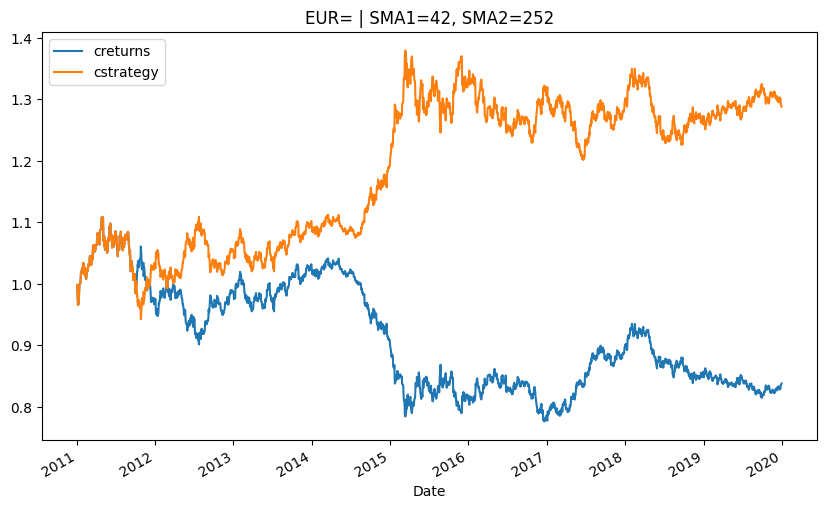

In [7]:
smabt.plot_results()

In [11]:
smabt.optimize_parameters((20, 50, 5), (50, 100, 5))

(array([35., 70.]), 1.63)

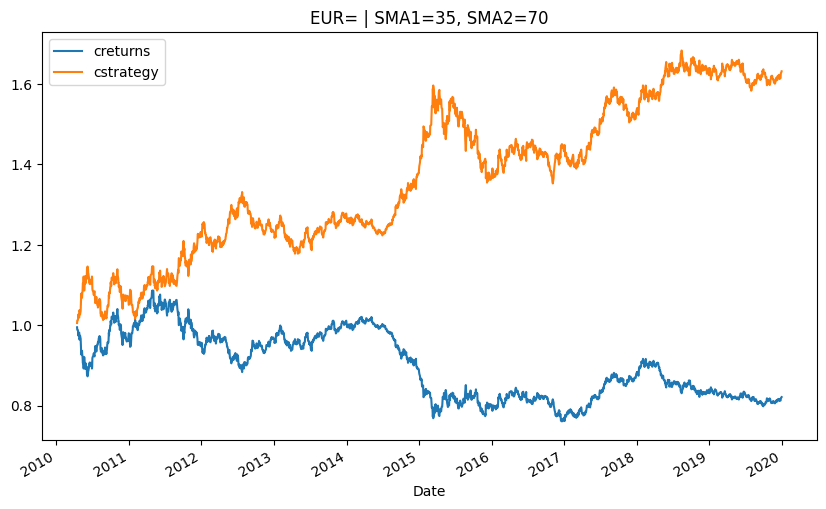

In [12]:
smabt.plot_results()